In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats, signal
from scipy.fft import fft

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Training data
train_data = pd.read_csv("cleaned_data/train_clean.csv", parse_dates=['date'], index_col=['date'])
# Frequency
train_data = train_data.asfreq('D')

# Merged data
merged_data = pd.read_csv("cleaned_data/merged_clean.csv", parse_dates=['date'], index_col=['date'])
# Frequency
merged_data = merged_data.asfreq('D')

## **Frequency Analysis**

**Frequency analysis** shows how a signal **energy** is distributed over a **range of frequencies**.

A time-series can be converted between the time and frequency domains with a pair of mathematical operators called a **transform** (*mainly, the **Fourier Transform***), which decomposes a function into the the sum of a number of sine/cosine wave frequency components.

It is used to identify any **periodicity** in the time series:
* A **period** is the time required to finish a complete cycle and can be measured from the two adjacent peaks. It is computed by: $$period=\frac{1}{frequency}$$

Moreover, to identify periodicity, **Power Spectral Density** (PSD) is needed: the most important representation of FFT.

It plots the **power** of each frequency component on the y-axis and the **frequency** on th x-axis.

To estimate it, the **periodogram** method will be used.

The periodicity found from the frequency analysis is key for a proper **seasonal decomposition**.

### `"meantemp"`

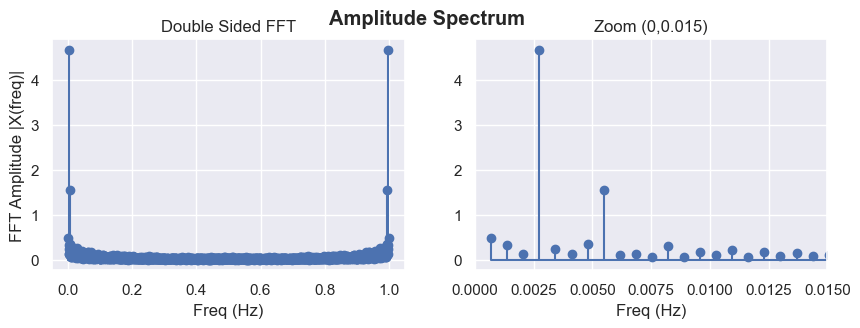

In [55]:
# Parameter definition
# Signal
signal_temp = train_data['meantemp'].values
# Sampling frequency
Fs = 1 # --> unit of measure is "days"

# Scipy "fft" Implementation
X = fft(signal_temp) # --> 1D DFT
N = len(X)

freq_step = Fs/N
freq_vec = np.arange(0, Fs, freq_step)[1:] # --> [1:] to avoid element index 0

peaks = np.abs(X)/N
peaks = peaks[1:] # --> [1:] to avoid element index 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
fig.suptitle('Amplitude Spectrum', weight='bold')
# Complete version (double sided)
axes[0].set_title('Double Sided FFT')
axes[0].stem(freq_vec, peaks, 'b', basefmt="-b")
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('FFT Amplitude |X(freq)|')
# Zoom version
axes[1].set_title('Zoom (0,0.015)')
axes[1].stem(freq_vec, peaks, 'b', basefmt="-b")
axes[1].set_xlabel('Frequency')
axes[1].set_xlim(0,0.015)
plt.show()


,Freq,Period,Power
0,0.002738,365.250,63722.724115
1,0.005476,182.625,6933.185395


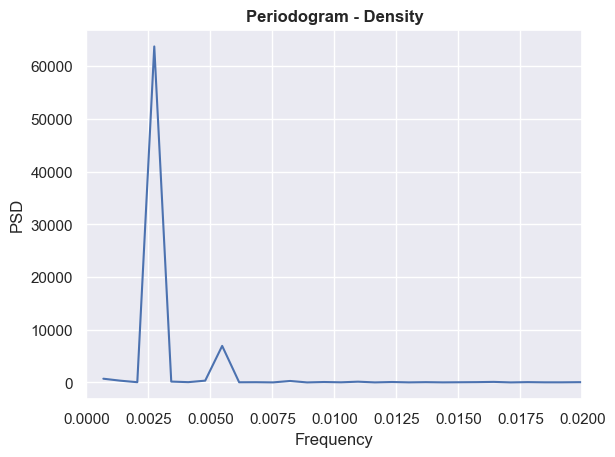

Frequency for the maximum value is:  0.0027378507871321013
Period (days/cycle):  365.25


In [56]:
# Power Spectral Density (PSD) with periodgram
f_per_density, Pxx_per_density = signal.periodogram(signal_temp,Fs,detrend=False,window='boxcar',nfft=None,return_onesided=True,scaling='density')
f_per_density = f_per_density[1:]
Pxx_per_density = Pxx_per_density[1:]

plt.plot(f_per_density, Pxx_per_density)
plt.title('Periodogram - Density', weight='bold')
plt.ylabel('PSD')
plt.xlim(0,0.02)
plt.xlabel('Frequency')


peaks = signal.find_peaks(Pxx_per_density[f_per_density >= 0], prominence=6000)[0]
peak_freq = f_per_density[peaks]
peak_power = Pxx_per_density[peaks]

table = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
tab = pd.DataFrame(table)
display(tab)

plt.show()

temp = np.where(Pxx_per_density == Pxx_per_density.max())

print('Frequency for the maximum value is: ',float(f_per_density[temp]))
print('Period (days/cycle): ',float(1/f_per_density[temp]))

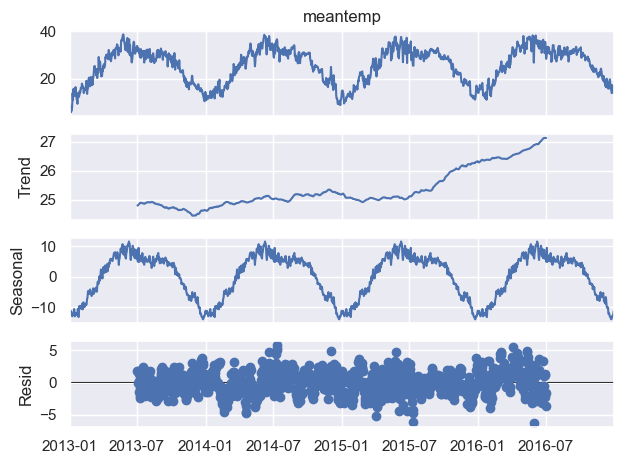

In [61]:
decompose_data = seasonal_decompose(train_data['meantemp'], model='additive', period=365)
decompose_data.plot()
plt.show()

### `"humidity"`